<a href="https://colab.research.google.com/github/isa-ulisboa/greends-pml/blob/main/Lesson3_edited_04-how-does-a-neural-net-really-work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fitting a function with *gradient descent*

A neural network is just a mathematical function. In the most standard kind of neural network, the function:

1. Multiplies each input by a number of values. These values are known as *parameters*
1. Adds them up for each group of values
1. Replaces the negative numbers with zeros

This represents one "layer". Then these three steps are repeated, using the outputs of the previous layer as the inputs to the next layer. Initially, the parameters in this function are selected randomly. Therefore a newly created neural network doesn't do anything useful at all -- it's just random!

To get the function to "learn" to do something useful, we have to change the parameters to make them "better" in some way. We do this using *gradient descent*. Let's see how this works...

In [1]:
from ipywidgets import interact
from fastai.basics import *

plt.rc('figure', dpi=90)

def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

To learn how gradient descent works, we're going to start by fitting a quadratic, since that's a function most of us are probably more familiar with than a neural network. Here's the quadratic we're going to try to fit:

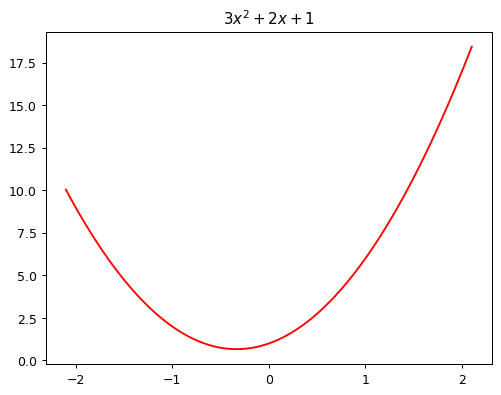

In [2]:
def f(x): return 3*x**2 + 2*x + 1

plot_function(f, "$3x^2 + 2x + 1$")

This quadratic is of the form $ax^2+bx+c$, with parameters $a=3$, $b=2$, $c=1$. To make it easier to try out different quadratics for fitting a model to the data we'll create, let's create a function that calculates the value of a point on any quadratic:

In [3]:
def quad(a, b, c, x): return a*x**2 + b*x + c

If we fix some particular values of a, b, and c, then we'll have made a quadratic. To fix values passed to a function in python, we use the `partial` function, like so:

In [4]:
def mk_quad(a,b,c): return partial(quad, a,b,c)

So for instance, we can recreate our previous quadratic:

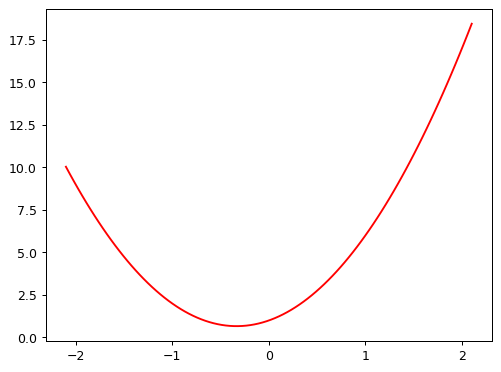

In [5]:
f2 = mk_quad(3,2,1)
plot_function(f2)

Now let's simulate making some noisy measurements of our quadratic `f`. We'll then use gradient descent to see if we can recreate the original function from the data.

Here's a couple of functions to add some random noise to data:

In [6]:
def noise(x, scale): return np.random.normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

Let's use the now to create our noisy measurements based on the quadratic above:

In [7]:
np.random.seed(42)

x = torch.linspace(-2, 2, steps=20)[:,None]
y = add_noise(f(x), 0.15, 1.5)

Here's the first few values of each of `x` and `y`:

In [8]:
x[:5],y[:5]

(tensor([[-2.0000],
         [-1.7895],
         [-1.5789],
         [-1.3684],
         [-1.1579]]),
 tensor([[11.8690],
         [ 6.5433],
         [ 5.9396],
         [ 2.6304],
         [ 1.7947]], dtype=torch.float64))

As you can see, they're *tensors*. A tensor is just like an `array` in numpy (if you're not familiar with numpy, I strongly recommend reading [this great book](https://wesmckinney.com/book/), because it's a critical foundation for nearly all numeric programming in Python. Furthermore, PyTorch, which most researchers use for deep learning, is modeled closely on numpy.) A tensor can be a single number (a *scalar* or *rank-0 tensor*), a list of numbers (a *vector* or *rank-1 tensor*), a table of numbers (a *matrix* or *rank-0 tensor*), a table of tables of numbers (a *rank-3 tensor*), and so forth.

We're not going to learn much about our data by just looking at the raw numbers, so let's draw a picture:

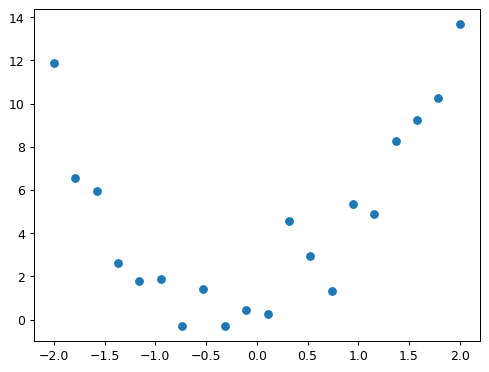

In [9]:
plt.scatter(x,y);

How do we find values of a, b, and c which fit this data? One approach is to try a few values and see what fits. Here's a function which overlays a quadratic on top of our data, along with some sliders to change a, b, and c, and see how it looks:

In [ ]:
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    plt.scatter(x,y)
    plot_function(mk_quad(a,b,c), ylim=(-3,13))

Try moving slider `a` a bit to the left. Does that look better or worse? How about if you move it a bit to the right? Find out which direction seems to improve the fit of the quadratic to the data, and move the slider a bit in that direction. Next, do the same for slider `b`: first figure out which direction improves the fit, then move it a bit in that direction. Then do the same for `c`.

OK, now go back to slider `a` and repeat the process. Do it again for `b` and `c` as well.

Did you notice that by going back and doing the sliders a second time that you were able to improve things a bit further? That's an important insight -- it's only after changing `b` and `c`, for instance, that you realise that `a` actually needs some adjustment based on those new values.

One thing that's making this tricky is that we don't really have a great sense of whether our fit is really better or worse. It would be easier if we had a numeric measure of that. On easy metric we could use is *mean absolute error* -- which is the distance from each data point to the curve:

In [14]:
def mae(preds, acts): return (torch.abs(preds-acts)).mean()

We'll update our interactive function to print this at the top for us.

Use this to repeat the approach we took before to try to find the best fit, but this time just use the value of the metric to decide which direction to move each slider, and how far to move it.

This time around, try doing it in the opposite order: `c`, then `b`, then `a`.

You'll probably find that you have to go through the set of sliders a couple of times to get the best fit.

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

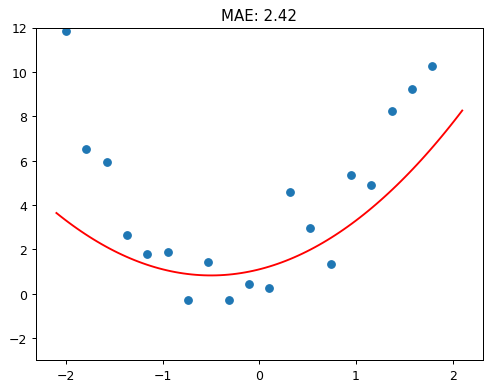

In [32]:
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    f = mk_quad(a,b,c)
    plt.scatter(x,y)
    loss = mae(f(x), y)
    plot_function(f, ylim=(-3,12), title=f"MAE: {loss:.2f}")

In a modern neural network we'll often have tens of millions of parameters to fit, or more, and thousands or millions of data points to fit them to. We're not going to be able to do that by moving sliders around! We'll need to automate this process.

Thankfully, that turns out to be pretty straightforward. We can use calculus to figure out, for each parameter, whether we should increase or decrease it.

Uh oh, calculus! If you haven't touched calculus since school, you might be getting ready to run away at this point. But don't worry, we don't actually need much calculus at all. Just derivatives, which measure the rate of change of a function. We don't even need to calculate them ourselves, because the computer will do it for us! If you've forgotten what a derivitive is, then watch the first three of these fantastic [videos by Professor Dave](https://www.youtube.com/playlist?list=PLybg94GvOJ9ELZEe9s2NXTKr41Yedbw7M). It's only 15 minutes in total, so give it a go! Then come back here and we'll continue on our journey...

## Automating gradient descent

The basic idea is this: if we know the *gradient* of our `mae()` function *with respect to* our parameters, `a`, `b`, and `c`, then that means we know how adjusting (for instance) `a` will change the value of `mae()`. If, say, `a` has a *negative* gradient, then we know that increasing `a` will decrease `mae()`. Then we know that's what we need to do, since we trying to make `mae()` as low as possible.

So, we find the gradient of `mae()` for each of our parameters, and then adjust our parameters a bit in the *opposite* direction to the sign of the gradient.

To do this, first we need a function that takes all the parameters `a`, `b`, and `c` as a single vector input, and returns the value `mae()` based on those parameters:

In [33]:
def quad_mae(params):
    f = mk_quad(*params)
    return mae(f(x), y)

Let's try it:

In [34]:
quad_mae([1.1, 1.1, 1.1])

tensor(2.4219, dtype=torch.float64)

Yup, that's the same as the starting `mae()` we had in our plot before.

We're first going to do exactly the same thing as we did manually -- pick some arbritrary starting point for our parameters. We'll put them all into a single tensor:

In [35]:
abc = torch.tensor([1.1,1.1,1.1])

To tell PyTorch that we want it to calculate gradients for these parameters, we need to call `requires_grad_()`:

In [36]:
abc.requires_grad_()

tensor([1.1000, 1.1000, 1.1000], requires_grad=True)

We can now calculate `mae()`. Generally, when doing gradient descent, the thing we're trying to minimise is called the *loss*:

In [37]:
loss = quad_mae(abc)
loss

tensor(2.4219, dtype=torch.float64, grad_fn=<MeanBackward0>)

To get PyTorch to now calculate the gradients, we need to call `backward()`

In [38]:
loss.backward()

The gradients will be stored for us in an attribute called `grad`:

In [39]:
abc.grad

tensor([-1.3529, -0.0316, -0.5000])

According to these gradients, all our parameters are a little low. So let's increase them a bit. If we subtract the gradient, multiplied by a small number, that should improve them a bit:

In [40]:
with torch.no_grad():
    abc -= abc.grad*0.01
    loss = quad_mae(abc)

print(f'loss={loss:.2f}')

loss=2.40


Yes, our loss has gone down!

The "small number" we multiply is called the *learning rate*, and is the most important *hyper-parameter* to set when training a neural network.

BTW, you'll see we had to wrap our calculation of the new parameters in `with torch.no_grad()`. That disables the calculation of gradients for any operations inside that context manager. We have to do that, because `abc -= abc.grad*0.01` isn't actually part of our quadratic model, so we don't want derivitives to include that calculation.

We can use a loop to do a few more iterations of this:

In [46]:
for i in range(10):
    loss = quad_mae(abc)
    loss.backward()
    with torch.no_grad(): abc -= abc.grad*0.01
    print('current parameters:',abc)
    print(f'step={i}; loss={loss:.2f}')

current parameters: tensor([ 2.2169,  1.5540, -0.2050], requires_grad=True)
step=0; loss=1.48
current parameters: tensor([ 2.1484,  1.5477, -0.3030], requires_grad=True)
step=1; loss=1.68
current parameters: tensor([ 2.0936,  1.5414, -0.3930], requires_grad=True)
step=2; loss=1.85
current parameters: tensor([ 2.0530,  1.5343, -0.4740], requires_grad=True)
step=3; loss=2.00
current parameters: tensor([ 2.0266,  1.5265, -0.5460], requires_grad=True)
step=4; loss=2.13
current parameters: tensor([ 2.0144,  1.5180, -0.6090], requires_grad=True)
step=5; loss=2.24
current parameters: tensor([ 2.0164,  1.5087, -0.6630], requires_grad=True)
step=6; loss=2.31
current parameters: tensor([ 2.0325,  1.4987, -0.7080], requires_grad=True)
step=7; loss=2.35
current parameters: tensor([ 2.0629,  1.4880, -0.7440], requires_grad=True)
step=8; loss=2.37
current parameters: tensor([ 2.1074,  1.4765, -0.7710], requires_grad=True)
step=9; loss=2.36


As you can see, our loss keeps going down!

If you keep running this loop for long enough however, you'll see that the loss eventually starts increasing for a while. That's because once the parameters get close to the correct answer, our parameter updates will jump right over the correct answer! To avoid this, we need to decrease our learning rate as we train. This is done using a *learning rate schedule*, and can be automated in most deep learning frameworks, such as fastai and PyTorch.